# Code to download all the files which are available on the EDGAR website.

*EDGAR Indices project :*
This project entails writing Python code that efficiently processes EDGAR index files to construct a data frame, enabling users to perform basic searches and analysis.
It has two main purposes:
1) Produce Python code that addresses a specific institutional need.
2) Learn about an important financial data repository and its contents as well as access.

Here with this, individual can:
1) Learn about EDGAR index files, their structure and content.
2) Download index files (daily, quarterly) directly from the SEC's EDGAR site (https://www.sec.gov/os/accessing-edgar-data).

For this project, we excluded the XBRL filings. Parse index files, and create a data frame that will have all the content from index files. (Save the dataframe for access in the future without resorting to EDGAR again.) Allow users query the dataframe based on Form type / CIK / Company Name to generate a list of filings for the filters the user entered. The user interface for this could be very basic. The goal is to be able to get a certain filing or a list of filings. Display a filing with a given/chosen URL.

In [ ]:
import requests
import os
import time

# Base URL for the SEC EDGAR full index
base_url = 'https://www.sec.gov/Archives/edgar/full-index/'

# Function to download the file, now includes headers parameter
def download_file(url, path, headers):
    with requests.get(url, headers=headers, stream=True) as r:
        r.raise_for_status()
        with open(path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

# Prompt for start and end year
start_year = int(input("Enter the start year (YYYY): "))
end_year = int(input("Enter the end year (YYYY): "))
save_dir = input('Please Input Path to Your Directory to Download Files:')

# Add your user-agent string here
headers = {'User-Agent': 'nc623367@wne.edu'}

# Iterate over each year and quarter within the specified range
for year in range(start_year, end_year + 1):
    for quarter in ['QTR1', 'QTR2', 'QTR3', 'QTR4']:
        file_url = f"{base_url}{year}/{quarter}/company.idx"
        save_path = os.path.join(save_dir, f"{year}_{quarter}_company.idx")

        print(f"Attempting to download {file_url}...")

        # Make the download attempt
        try:
            download_file(file_url, save_path, headers)
            print(f"Successfully downloaded {file_url}")
        except Exception as e:
            print(f"Failed to download {file_url}. Error: {e}")

        # Respect the SEC's rate limiting
        time.sleep(1)  # Sleep for 1 second to avoid hitting rate limit

print("All requested files have been attempted to download.")

# Get the required files based on the User interest

Here we define functions to get the company data based on the User search type i.e.,

1) Time Period of Filings
2) Compnay Name
3) CIK

In [ ]:
import pandas as pd  # Importing pandas for data manipulation
import os  # Importing os for file and directory operations

# Adjusting pandas display options for more optimized data viewing
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', None)  # Automatically adjust display width to terminal size
pd.set_option('display.max_colwidth', None)  # Display full content of each cell

# Function to load EDGAR index files from a specified year and directory
def load_data(year, source_dir):
    colspecs = [(0, 62), (62, 74), (74, 86), (86, 98), (98, None)]  # Column widths in fixed-width file
    column_names = ['Company Name', 'Form Type', 'CIK', 'Date Filed', 'Filename']  # Names of columns
    dataframe_collection = []  # List to store dataframes for each quarter

    # Loop through each quarter
    for quarter in ['QTR1', 'QTR2', 'QTR3', 'QTR4']:
        file_name = f'{year}_{quarter}_company.idx'  # Construct filename for each quarter
        file_path = os.path.join(source_dir, file_name)  # Create full path to the file

        # Check if the file exists before trying to open it
        if os.path.exists(file_path):
            try:
                # Read fixed-width file with specified columns and skip header rows using skiprows
                temp_df = pd.read_fwf(file_path, colspecs=colspecs, skiprows=9, names=column_names)
                dataframe_collection.append(temp_df)  # Add dataframe to the collection
            except UnicodeDecodeError as e:
                # Handle errors that occur if the file has encoding issues
                print(f'Error reading {file_name}: {e}')
                continue
            except Exception as e:
                # Handle other unexpected errors during file reading
                print(f'An unexpected error occurred while reading {file_name}: {e}')
                continue

    # Check if any data was loaded successfully
    if not dataframe_collection:
        print("No data was loaded. Please check your file paths and names.")
        return pd.DataFrame()  # Return an empty DataFrame if no data was loaded

    # Concatenate all quarterly DataFrames into one DataFrame
    all_data_df = pd.concat(dataframe_collection, ignore_index=True)
    all_data_df.columns = all_data_df.columns.str.strip()  # Strip any leading/trailing whitespace from column names
    return all_data_df  # Return the concatenated DataFrame

# Function to filter the DataFrame by company name or CIK
def find_companies_or_cik(all_data_df, search_term, search_type):
    try:
        if search_type == 'name':
            # Filter DataFrame by company name, ignoring case
            matching = all_data_df[all_data_df['Company Name'].str.contains(search_term, case=False, na=False)]
        else:  # search by 'cik'
            # Filter DataFrame by CIK
            matching = all_data_df[all_data_df['CIK'].astype(str) == str(search_term)]
        # Return filtered DataFrame with duplicate entries removed
        return matching[['Company Name', 'CIK']].drop_duplicates().reset_index(drop=True)
    except Exception as e:
        # Handle any errors that occur during filtering
        print(f"An error occurred during search: {e}")
        return pd.DataFrame()  # Return an empty DataFrame if an error occurs

# Function to get all filings for a specific CIK in a given year
def get_filings_for_company(all_data_df, cik, year):
    try:
        # Filter DataFrame for filings by the specified CIK and year
        filings_df = all_data_df[
            (all_data_df['CIK'] == cik) &
            (all_data_df['Date Filed'].str.contains(str(year)))
        ].reset_index(drop=True)
        return filings_df  # Return the filtered DataFrame
    except Exception as e:
        # Handle any errors during the filtering
        print(f"An error occurred while fetching filings for company CIK {cik}: {e}")
        return pd.DataFrame()  # Return an empty DataFrame if an error occurs

# Function to display filings and allow the user to select one to view its URL
def display_and_choose_filings(filings_df):
    try:
        if filings_df.empty:
            # Check if the DataFrame is empty (no filings found)
            print("No filings found for this company.")
            return None

        # Display available filings for selection
        print(filings_df[['Form Type', 'Date Filed', 'Filename']])
        index_to_display = int(input("Enter the index number of the filing to display: "))
        # Validate user input
        if index_to_display >= len(filings_df):
            print("Invalid index number. Please enter a valid index from the list.")
            return None

        # Get the selected filing based on user input
        selected_filing = filings_df.iloc[index_to_display]
        # Construct the URL to view the filing
        filing_url = 'https://www.sec.gov/Archives/' + selected_filing['Filename']
        print(f"You can view the filing at the following URL:\n{filing_url}")
        return filing_url  # Return the URL
    except ValueError:
        # Handle invalid numeric input
        print("Invalid input. Please enter a numerical index.")
        return None
    except Exception as e:
        # Handle any other errors
        print(f"An error occurred while selecting filings: {e}")
        return None

if __name__ == "__main__":
    try:
        # Prompt user for the year of the filings to search
        year = int(input("Enter the exact year of the filings you want to search: "))
        print('Your Range of Data is:', year)
        
        # Prompt user for the type of search (name or CIK)
        search_type = input("Enter your choice of search : 'name' or 'CIK'? : ").lower()

        # Get the search term from the user based on the search type
        if search_type == 'name':
            search_term = input("Enter the company name to search for: ")
        else:
            search_term = input("Enter the CIK to search for: ").lstrip('0')

        # Ask user for the directory where the .idx files are stored
        source_dir = input('Please input the directory of your .idx files : ')
        
        # Load data from the specified year and directory
        user_data_df = load_data(year, source_dir)
        if user_data_df.empty:
            # Check if data was loaded successfully
            print("Data loading failed. Please check the file paths and year input.")
        else:
            print("Data loaded successfully. Here are the column names:")
            print(user_data_df.columns.tolist())

            # Validate the search type
            if search_type not in ['name', 'cik']:
                print("Invalid search type entered. Please restart and enter either 'name' or 'CIK'.")
            else:
                # Find matching companies or CIKs based on the search term and type
                matching_entities = find_companies_or_cik(user_data_df, search_term, search_type)
                if matching_entities.empty:
                    print(f"No matching entities found for the given {search_type}.")
                else:
                    print("Matching companies/CIKs:")
                    print(matching_entities)

                    # Handle filings retrieval based on the search type
                    if search_type == 'cik':
                        filings_df = get_filings_for_company(user_data_df, search_term, year)
                        display_and_choose_filings(filings_df)
                    elif search_type == 'name':
                        # Allow user to select a company from the list
                        company_index = int(input("Enter the index number of the company to display filings for: "))
                        if company_index not in matching_entities.index:
                            print("Invalid index number. Please enter a valid index from the list.")
                        else:
                            # Retrieve and display filings for the selected company
                            selected_cik = matching_entities.at[company_index, 'CIK']
                            filings_df = get_filings_for_company(user_data_df, selected_cik, year)
                            display_and_choose_filings(filings_df)

    except ValueError:
        # Handle errors caused by incorrect numeric input
        print("You have entered an invalid year or index number. Please restart and enter a valid number.")
    except Exception as e:
        # Handle any other exceptions that may occur
        print(f"An unexpected error occurred: {e}")

# Code to Create a Dataframe and Save it as *CSV* file in Local Repository

In [ ]:
import pandas as pd
import os

# Adjusting pandas display options for more optimized data viewing
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', None)  # Automatically adjust display width to terminal size
pd.set_option('display.max_colwidth', None)  # Display full content of each cell

#Load data from all EDGAR index files in the specified director
def load_data_from_directory(source_dir):
    colspecs = [(0, 62), (62, 74), (74, 86), (86, 98), (98, None)]
    column_names = ['Company Name', 'Form Type', 'CIK', 'Date Filed', 'Filename']
    dataframe_collection = []

    # Iterate over each file in the directory
    for file_name in os.listdir(source_dir):
        if file_name.endswith('.idx'):  # Check for .idx files
            file_path = os.path.join(source_dir, file_name)
            try:
                # Read fixed-width file with specified columns and skip header rows
                temp_df = pd.read_fwf(file_path, colspecs=colspecs, skiprows=9, names=column_names)
                dataframe_collection.append(temp_df)
            except UnicodeDecodeError as e:
                print(f'Error reading {file_name}: {e}')
                continue
            except Exception as e:
                print(f'An unexpected error occurred while reading {file_name}: {e}')
                continue

    if not dataframe_collection:
        print("No data was loaded. Please check your file paths and names.")
        return pd.DataFrame()

    # Concatenate all DataFrames into one DataFrame
    combined_df = pd.concat(dataframe_collection, ignore_index=True)
    combined_df.columns = combined_df.columns.str.strip()  # Strip any leading/trailing whitespace from column names
    return combined_df

def save_to_csv(df, output_path):
    """Save DataFrame to a CSV file."""
    try:
        df.to_csv(output_path, index=False)
        print(f"Data saved successfully to {output_path}")
    except Exception as e:
        print(f"Failed to save the DataFrame: {e}")

# Main execution logic
if __name__ == "__main__":
    source_directory = input('Enter/path/to/data/directory: ')  # Get directory containing the data files from user
    csv_name = input('Enter the filename for the CSV (e.g., combined_data.csv): ')
    output_path = os.path.join(source_directory, csv_name)  # Construct the full path to save the CSV file

    # Load data from the specified directory
    all_data_df = load_data_from_directory(source_directory)

    # Save the data to a CSV file
    if not all_data_df.empty:
        save_to_csv(all_data_df, output_path)
    else:
        print("No data to save.")


# Data Analysis and Visualization of the EDGAR Data


With the Data gathered above, we can analyse with the use of *statistical analysis* and *data visualization*.
We can try to answer the following questions : 
1) Time series counts of filings per year/quarter/month.
2) Is there a seasonality? For instance, are there more filings in a particular month?
3) Top N filers / Top N filing types Summary statistics of filings over quarters/ months: min/max/mean/median/sd of filings.
4) Are there correlations between certain types of filings?.
5) Does the company name ever change for a given CIK? How often? How many instances do you notice?

If Your Environment doesn't have the required libraries install, then run the first cell to install the required packages.

In [1]:
pip install pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [1]:
#Importing required Libraries
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

In [2]:
#Creating the dataframe from the local repository
file_path = input('Path/to/file.csv:')
df = pd.read_csv(file_path)
df.head()

Path/to/file.csv: /Users/nareshchethala/Desktop/Project/Project_Dataframes/complete_edgar_data.csv


/var/folders/kk/9wmt5z851yxcb3jnsdggq1lw0000gn/T/ipykernel_86051/4034058990.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


,Company Name,Form Type,CIK,Date Filed,Filename
0,----------------------------------------------...,------------,------------,------------,-------------------------------------------
1,1 800 FLOWERS COM INC,10-K,1084869,2020-09-11,edgar/data/1084869/0001437749-20-019622.txt
2,1 800 FLOWERS COM INC,3,1084869,2020-07-02,edgar/data/1084869/0001437749-20-014500.txt
3,1 800 FLOWERS COM INC,4,1084869,2020-09-02,edgar/data/1084869/0001437749-20-019189.txt
4,1 800 FLOWERS COM INC,4,1084869,2020-09-02,edgar/data/1084869/0001437749-20-019193.txt


# Data Modelling

In [13]:
#Data Cleaning to remove filings with no dates
# Remove rows where 'Date Filed' contains '------------'
df = df[df['Date Filed'] != '------------']

# Printing the data with valid Date column
print(df)

                   Company Name Form Type      CIK Date Filed  \
1         1 800 FLOWERS COM INC      10-K  1084869 2020-09-11   
2         1 800 FLOWERS COM INC         3  1084869 2020-07-02   
3         1 800 FLOWERS COM INC         4  1084869 2020-09-02   
4         1 800 FLOWERS COM INC         4  1084869 2020-09-02   
5         1 800 FLOWERS COM INC         4  1084869 2020-09-02   
...                         ...       ...      ...        ...   
23368908             ZYMETX INC         4   921439 2001-12-12   
23368909             ZYMETX INC         4   921439 2001-12-12   
23368910             ZYMETX INC   NT 10-Q   921439 2001-11-14   
23368911             ZYMETX INC      SB-2   921439 2001-12-28   
23368912       ZYMOGENETICS INC     S-1/A  1129425 2001-11-02   

                                             Filename  Month  Year Month_Name  
1         edgar/data/1084869/0001437749-20-019622.txt      9  2020        NaN  
2         edgar/data/1084869/0001437749-20-014500.txt      

In [14]:
# Convert 'Date Filed' to datetime if it's not already
df['Date Filed'] = pd.to_datetime(df['Date Filed'])

# Extract month and year from 'Date Filed'
df['Month'] = df['Date Filed'].dt.month
df['Year'] = df['Date Filed'].dt.year
df.head()

,Company Name,Form Type,CIK,Date Filed,Filename,Month,Year,Month_Name
1,1 800 FLOWERS COM INC,10-K,1084869,2020-09-11,edgar/data/1084869/0001437749-20-019622.txt,9,2020,NaN
2,1 800 FLOWERS COM INC,3,1084869,2020-07-02,edgar/data/1084869/0001437749-20-014500.txt,7,2020,NaN
3,1 800 FLOWERS COM INC,4,1084869,2020-09-02,edgar/data/1084869/0001437749-20-019189.txt,9,2020,NaN
4,1 800 FLOWERS COM INC,4,1084869,2020-09-02,edgar/data/1084869/0001437749-20-019193.txt,9,2020,NaN
5,1 800 FLOWERS COM INC,4,1084869,2020-09-02,edgar/data/1084869/0001437749-20-019199.txt,9,2020,NaN


In [15]:
#Creating a dictionary for month names and mapping them to create a new column
month_names = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sept',10:'Oct',11:'Nov',12:'Dec'}
df['Month_Name'] = df['Month'].map(month_names)
df.head()

,Company Name,Form Type,CIK,Date Filed,Filename,Month,Year,Month_Name
1,1 800 FLOWERS COM INC,10-K,1084869,2020-09-11,edgar/data/1084869/0001437749-20-019622.txt,9,2020,Sept
2,1 800 FLOWERS COM INC,3,1084869,2020-07-02,edgar/data/1084869/0001437749-20-014500.txt,7,2020,Jul
3,1 800 FLOWERS COM INC,4,1084869,2020-09-02,edgar/data/1084869/0001437749-20-019189.txt,9,2020,Sept
4,1 800 FLOWERS COM INC,4,1084869,2020-09-02,edgar/data/1084869/0001437749-20-019193.txt,9,2020,Sept
5,1 800 FLOWERS COM INC,4,1084869,2020-09-02,edgar/data/1084869/0001437749-20-019199.txt,9,2020,Sept


# Analytics

In [16]:
#getting summary of each column
df['Form Type'].describe()

count     23368795
unique         723
top              4
freq       8516229
Name: Form Type, dtype: object

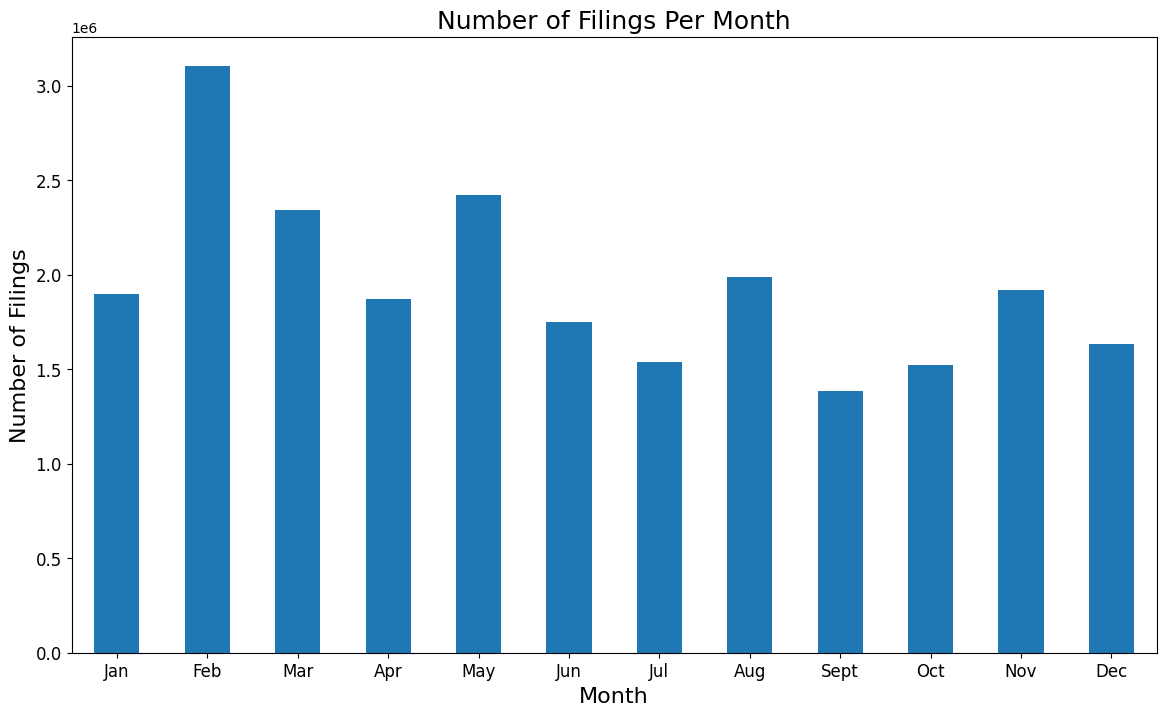

In [21]:
# Convert the 'Month_Name' column to a categorical type with a defined order
df['Month_Name'] = pd.Categorical(df['Month_Name'], categories=month_names.values(), ordered=True)

# Count filings per month
monthly_filings = df.groupby('Month_Name', observed=True).size()

# Sort counts in ascending order(optional, you can remove this, if you want the months to be in sequence)
#monthly_filings_sorted = monthly_filings.sort_values()

# Plotting the results
plt.figure(figsize=(14, 8))
monthly_filings.plot(kind='bar')
plt.title('Number of Filings Per Month', fontsize = 18)
plt.xlabel('Month', fontsize = 16)
plt.ylabel('Number of Filings', fontsize = 16)
plt.xticks(rotation=0, fontsize = 12)
plt.yticks(rotation=0, fontsize = 12)
plt.show()

In [22]:
# User input for form type
user_form_type = input("Enter the form type you are interested in (e.g., 10-K, 10-Q): ")

# Filter DataFrame for the specific form type
filtered_df = df[df['Form Type'] == user_form_type]

if not filtered_df.empty:
    # Function to find the month with the most filings
    most_frequent_month = filtered_df['Month_Name'].value_counts().idxmax() 
    #idmax is used to get the first one in the list based on index i.e., Month_Name

    print(f"The month with the most filings for {user_form_type} is: {most_frequent_month}")
else:
    print(f"No filings found for form type '{user_form_type}'.")

Enter the form type you are interested in (e.g., 10-K, 10-Q):  4


The month with the most filings for 4 is: Feb


Enter the form type you are interested in (e.g., 10-K, 10-Q):  4


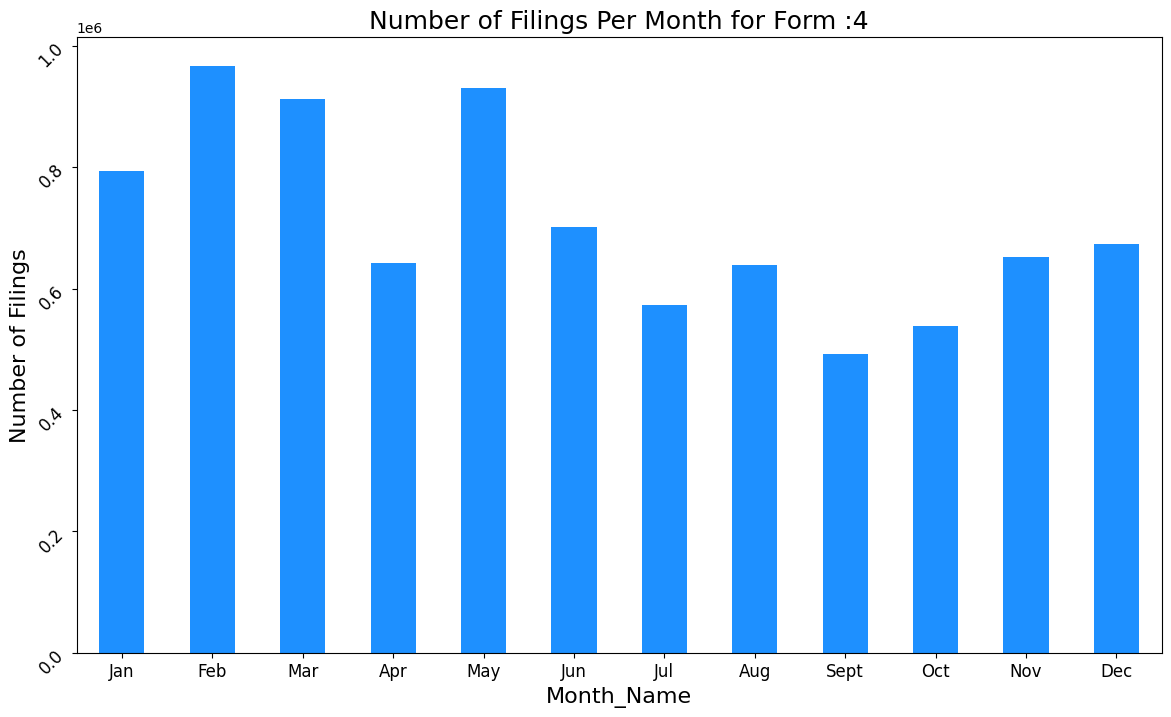

In [25]:
# User input for form type
user_form_type = input("Enter the form type you are interested in (e.g., 10-K, 10-Q): ")

# Filter DataFrame for the specific form type
filtered_df = df[df['Form Type'] == user_form_type]

if not filtered_df.empty:
    # Count the number of filings per month
    filings_per_month = filtered_df.groupby('Month_Name', observed = True).size()

    # Plotting the results
    plt.figure(figsize=(12, 6))
    filings_per_month.plot(kind='bar', color='dodgerblue', figsize = (14,8))
    plt.title(f'Number of Filings Per Month for Form - {user_form_type}',fontsize = 18)
    plt.xlabel('Month_Name',fontsize = 16)
    plt.ylabel('Number of Filings',fontsize =16)
    plt.xticks(rotation=0, fontsize = 12)
    plt.yticks(rotation = 45, fontsize = 12)
    plt.show()
else:
    print(f"No filings found for form type '{user_form_type}'.")


In [ ]:
# Calculating different statistics
mean_value = df['Form Type'].mean()
median_value = df['Form Type'].median()
std_dev = df['Form Type'].std()
min_value = df['Form Type'].min()
max_value = df['Form Type'].max()

# Printing the statistics
print(f"Mean (Average): {mean_value}")
print(f"Median: {median_value}")
print(f"Standard Deviation: {std_dev}")
print(f"Minimum Value: {min_value}")
print(f"Maximum Value: {max_value}")

# Getting a summary of statistics
summary = df['Form Type'].describe()
print("\nSummary Statistics:")
print(summary)

#Optional, run this if you want to get the Form Types into a List
#Creating a list of Form Type
df_form_list = df['Form Type'].unique().tolist()

#Specify the file path where you want to save the list
file_path = input('/Path/to/save/form_list.txt:')

#Writing the list to a text file and saving the file as per the user path
with open(file_path, 'w') as file:
    for item in df_form_list:
        file.write(f"{item}\n")

print(f"List saved to {file_path}")


In [27]:
#Getting the unique count of the Form Types
dfcount = df['Form Type'].value_counts()
dfcount

Form Type
4           8516229
8-K         1869862
SC 13G/A     818930
3            772883
10-Q         657499
             ...   
PREA14C           1
NTN15D2           1
ADV/A             1
26                1
10-QSB/A          1
Name: count, Length: 723, dtype: int64

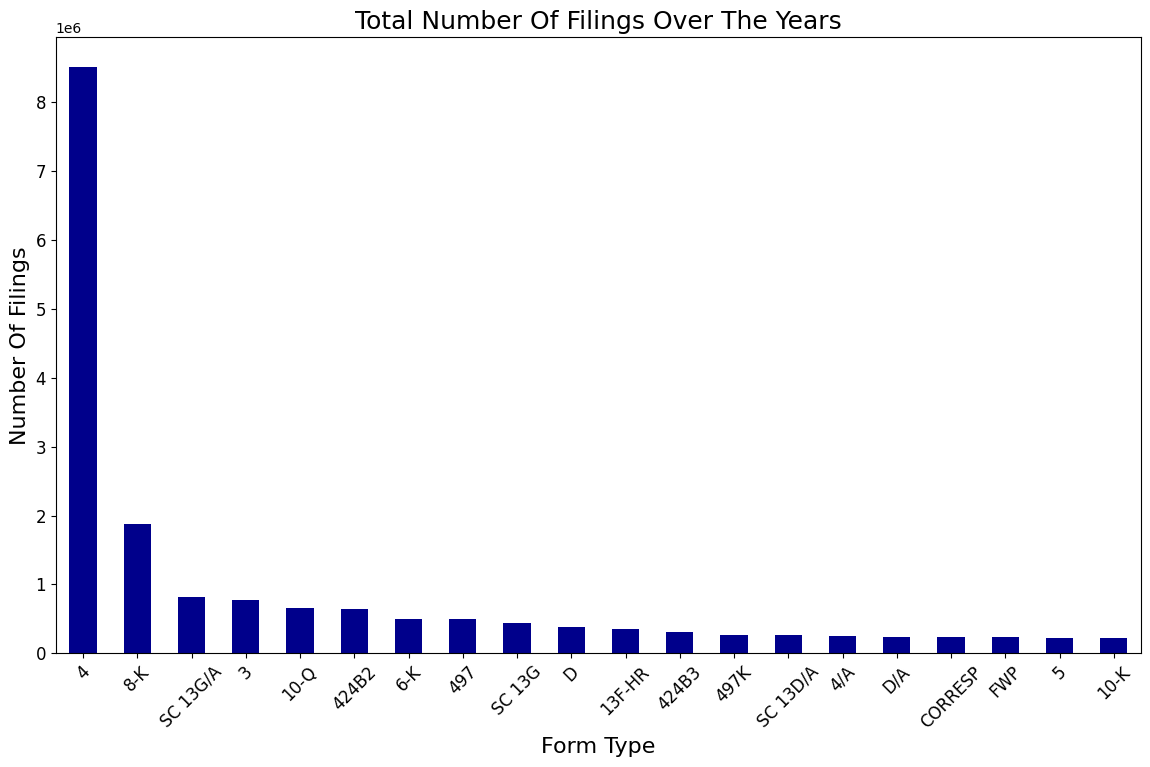

In [29]:
#Plotting the top 20 Form Types with most filings
dfcount[0:20].plot(kind = 'bar', color ='darkblue', figsize =(14,8))
plt.title('Total Number Of Filings Over The Years', fontsize = 18)
plt.xlabel('Form Type', fontsize = 16)
plt.ylabel('Number Of Filings', fontsize = 16)
plt.xticks(rotation=45,  fontsize = 12)
plt.yticks(rotation=0, fontsize = 12)
plt.show()

In [30]:
#To get the latest Date in the data
latest_date = df['Date Filed'].max()

In [31]:
# Calculating last 10 years based on the latest_date
ten_years_ago = latest_date - pd.DateOffset(years=10)

In [32]:
# Filtering data for the last 10 years
df_last_10_years = df[df['Date Filed'] >= ten_years_ago]

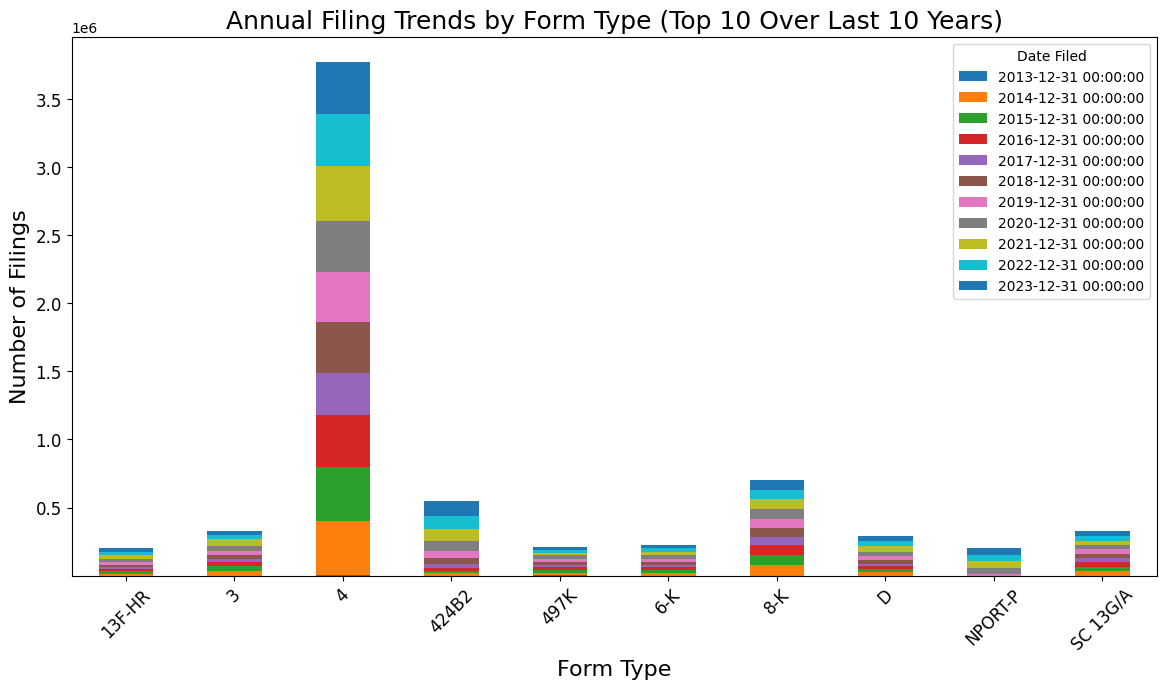

In [34]:
# Calculate frequency of each filing type and get top 10
top_filings = df_last_10_years['Form Type'].value_counts().nlargest(10)
top_filing_types = top_filings.index.tolist()

# Filter the DataFrame to include only top 10 filing types from the last 10 years
df_top10_last10 = df_last_10_years[df_last_10_years['Form Type'].isin(top_filing_types)]

# Group by Form Type and resample by year for trend analysis
trend_analysis = df_top10_last10.groupby('Form Type').resample('YE', on='Date Filed').count()

# Plotting the annual trend analysis as a stacked bar chart
trend_analysis['CIK'].unstack().plot(kind='bar', figsize=(14, 7), stacked=True)
plt.title('Annual Filing Trends by Form Type (Top 10 Over Last 10 Years)',fontsize=18)
plt.ylabel('Number of Filings', fontsize=16)
plt.xlabel('Form Type', fontsize=16)
plt.xticks(rotation=45, fontsize = 12)
plt.yticks(rotation=0, fontsize = 12)
plt.show()

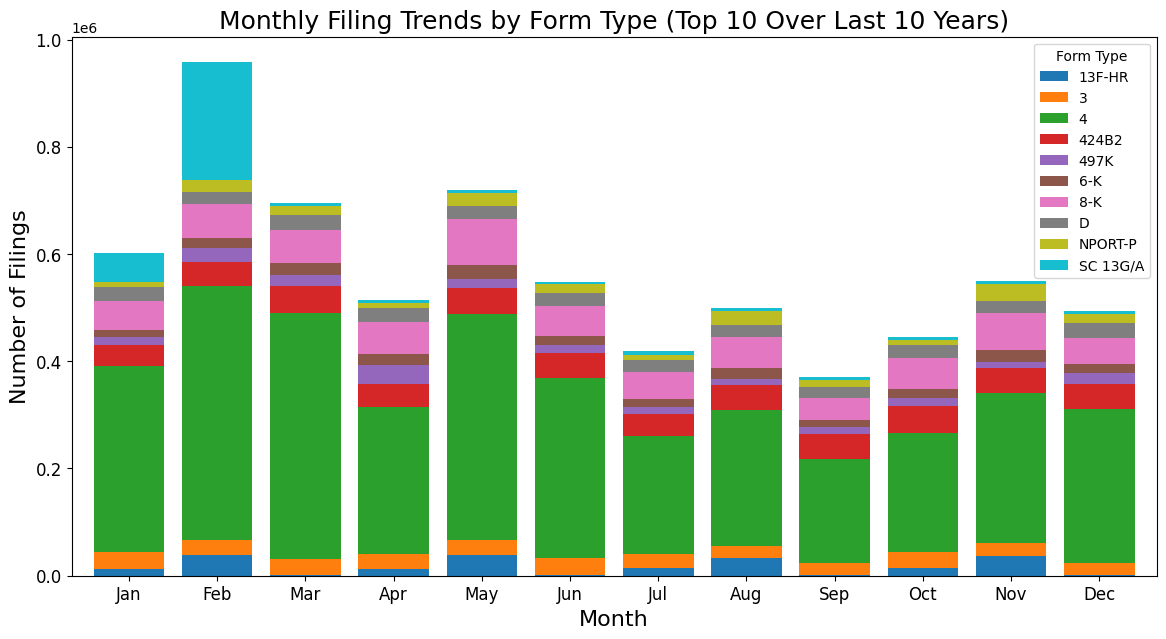

In [35]:
# Seasonality Analysis for top 10 filings over the last 10 years
df_top10_last10.loc[:, 'Month'] = df_top10_last10['Date Filed'].dt.month
seasonality_analysis = df_top10_last10.groupby(['Month', 'Form Type']).size().unstack()

# Plot the monthly trends for the top 10 filings as a stacked bar chart
seasonality_analysis.plot(kind='bar', figsize=(14, 7), width=0.8, stacked=True)
plt.title('Monthly Filing Trends by Form Type (Top 10 Over Last 10 Years)', fontsize = 18)
plt.ylabel('Number of Filings', fontsize = 16)
plt.xlabel('Month', fontsize = 16)
plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0, fontsize =12)
plt.yticks(fontsize =12)
plt.show()

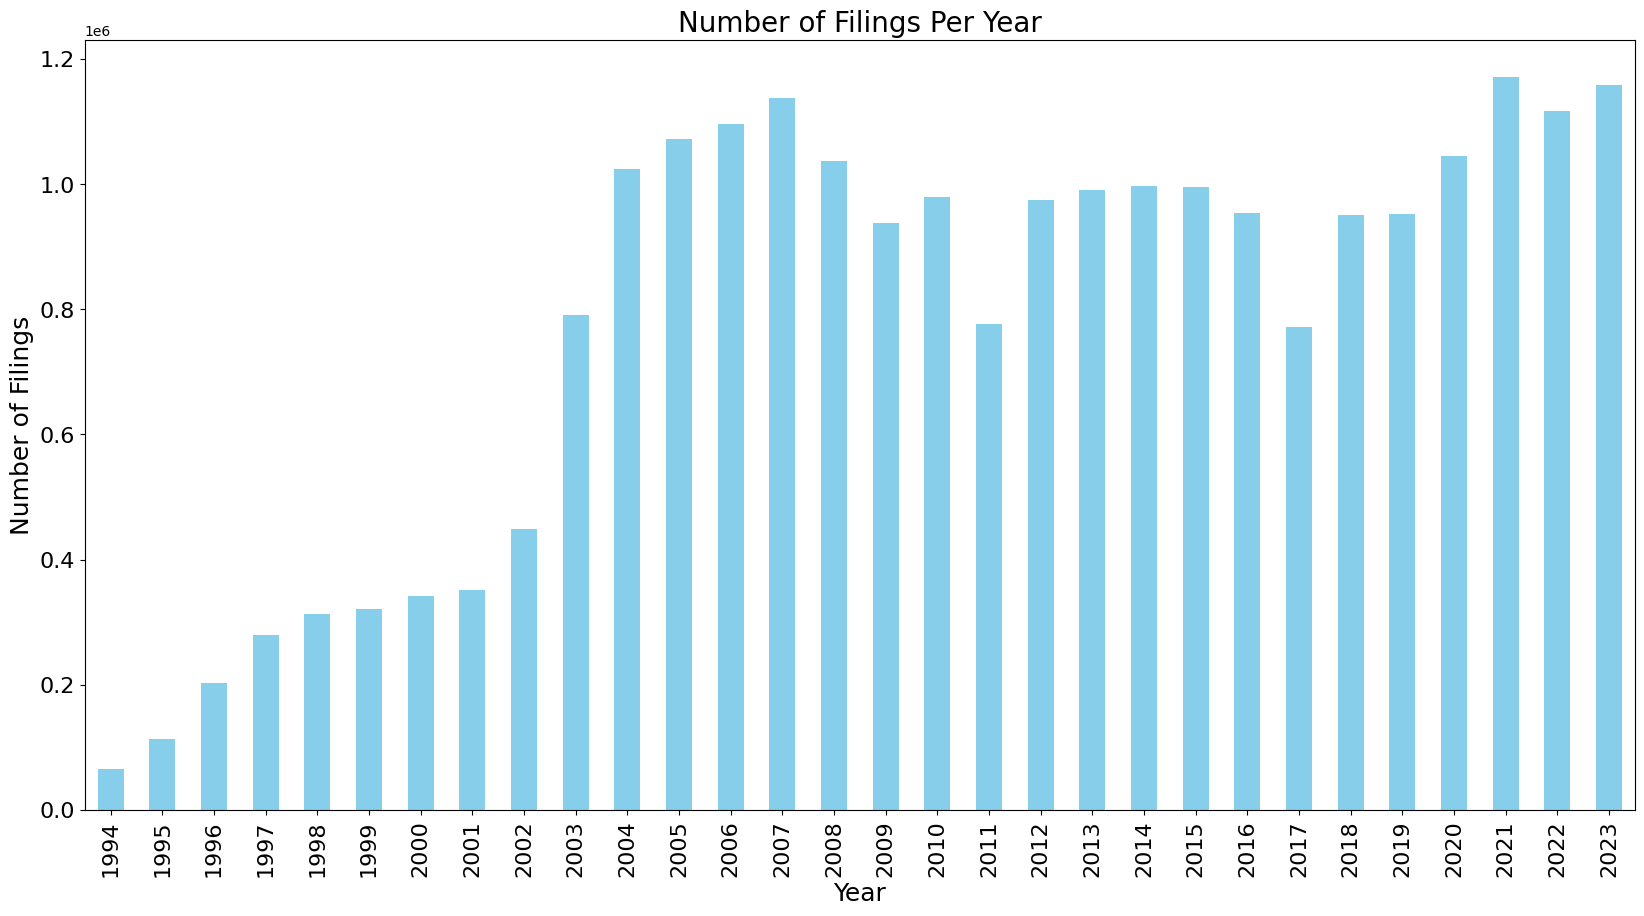

In [36]:
# Count filings per month
yearly_filings = df.groupby('Year').size()

# Sort counts in ascending order(optional, you can remove this, if you want the months to be in sequence)
#monthly_filings_sorted = monthly_filings.sort_values()

# Plotting the results
yearly_filings.plot(kind='bar',color = 'skyblue', figsize =(20,10))
plt.title('Number of Filings Per Year', fontsize = 20)
plt.xlabel('Year', fontsize = 18)
plt.ylabel('Number of Filings', fontsize = 18)
plt.xticks(rotation=90, fontsize = 16)
plt.yticks(rotation=0, fontsize = 16)
plt.show()